In [5]:
!pip install opencv-python-headless

In [6]:
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import os

In [7]:
def read_image(file_path):
    rgb_image = cv2.imread(file_path)
    return rgb_image

In [9]:
X = []
y = []

df = pd.read_csv('gtzan_features_3_sec.csv')
dataset_path = "gtzan"
for index, row in tqdm(df.iterrows()):
    try:
        file_path = os.path.join(dataset_path, row["label"] + "/" + row["filename"].replace(".", "_", 2).split(".")[0] + ".jpg").replace("\\", "/")
        image_rgb_matrix = read_image(file_path)
        image_rgb_matrix = image_rgb_matrix.astype('float32') / 255.0 # NORMALIZE RGB VALUES IN [0,1]
        label = row["label"]
        X.append(image_rgb_matrix)
        y.append(label)
    except:
        print("File error")
X = np.array(X)
y = np.array(y)
print(X.shape)
print(y.shape)

5438it [00:02, 2125.82it/s][ WARN:0@2054.462] global loadsave.cpp:248 findDecoder imread_('gtzan/jazz/jazz_00054_0.jpg'): can't open/read file: check file path/integrity
[ WARN:0@2054.463] global loadsave.cpp:248 findDecoder imread_('gtzan/jazz/jazz_00054_1.jpg'): can't open/read file: check file path/integrity
[ WARN:0@2054.463] global loadsave.cpp:248 findDecoder imread_('gtzan/jazz/jazz_00054_2.jpg'): can't open/read file: check file path/integrity
[ WARN:0@2054.463] global loadsave.cpp:248 findDecoder imread_('gtzan/jazz/jazz_00054_3.jpg'): can't open/read file: check file path/integrity
[ WARN:0@2054.463] global loadsave.cpp:248 findDecoder imread_('gtzan/jazz/jazz_00054_4.jpg'): can't open/read file: check file path/integrity
[ WARN:0@2054.463] global loadsave.cpp:248 findDecoder imread_('gtzan/jazz/jazz_00054_5.jpg'): can't open/read file: check file path/integrity
[ WARN:0@2054.463] global loadsave.cpp:248 findDecoder imread_('gtzan/jazz/jazz_00054_6.jpg'): can't open/read file

File error
File error
File error
File error
File error
File error
File error
File error
File error
File error


9990it [00:04, 2033.79it/s]


(9980, 130, 128, 3)
(9980,)


In [10]:
labelencoder = LabelEncoder()
y = labelencoder.fit_transform(y)
len(labelencoder.classes_)

# To see the mapping, you can create a dictionary using the classes_ attribute
label_mapping = dict(zip(labelencoder.classes_, labelencoder.transform(labelencoder.classes_)))

print("Label Mapping:", label_mapping)

Label Mapping: {'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(7984, 130, 128, 3)
(7984,)
(1996, 130, 128, 3)
(1996,)


In [12]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(130, 128, 3))
for layer in base_model.layers:
    layer.trainable = False
for layer in base_model.layers[-25:]:
    layer.trainable = True

model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(10, activation='softmax')
    ])
optimizer = Adam(learning_rate=0.00001)
model.summary()
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))
model.save('gtzan_resnet.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 24,114,826
Trainable params: 10,517,258
Non-trainable params: 13,597,568
___________________________________

2024-05-26 15:14:55.951599: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1594245120 exceeds 10% of free system memory.


250/250 [==============================] - ETA: 0s - loss: 1.8785 - accuracy: 0.3238

2024-05-26 15:17:59.530071: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 398561280 exceeds 10% of free system memory.


250/250 [==============================] - 208s 814ms/step - loss: 1.8785 - accuracy: 0.3238 - val_loss: 2.2393 - val_accuracy: 0.1242
Epoch 2/10
250/250 [==============================] - 203s 813ms/step - loss: 1.5711 - accuracy: 0.4401 - val_loss: 1.6280 - val_accuracy: 0.4279
Epoch 3/10
250/250 [==============================] - 198s 792ms/step - loss: 1.4540 - accuracy: 0.4838 - val_loss: 1.5415 - val_accuracy: 0.4434
Epoch 4/10
250/250 [==============================] - 200s 800ms/step - loss: 1.3735 - accuracy: 0.5110 - val_loss: 1.3452 - val_accuracy: 0.5266
Epoch 5/10
250/250 [==============================] - 206s 824ms/step - loss: 1.3123 - accuracy: 0.5309 - val_loss: 1.4112 - val_accuracy: 0.4960
Epoch 6/10
250/250 [==============================] - 203s 812ms/step - loss: 1.2606 - accuracy: 0.5531 - val_loss: 1.4784 - val_accuracy: 0.4880
Epoch 7/10
250/250 [==============================] - 200s 802ms/step - loss: 1.2206 - accuracy: 0.5668 - val_loss: 1.3768 - val_accura

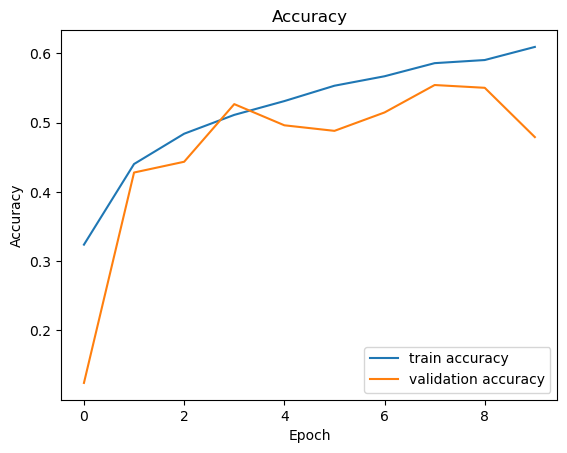

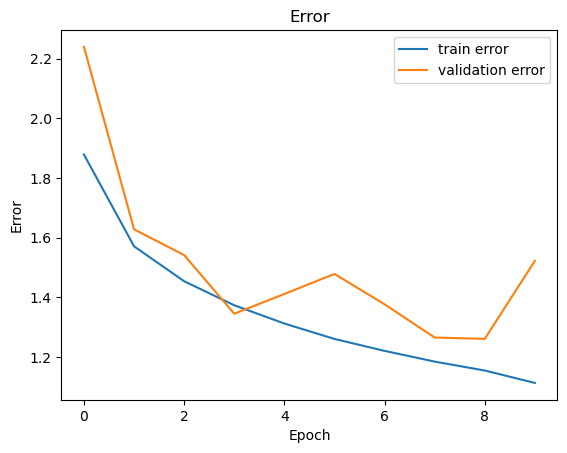

In [13]:
from matplotlib import pyplot as plt
plt.figure(1)
plt.plot(history.history["accuracy"], label="train accuracy")
plt.plot(history.history["val_accuracy"], label="validation accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(loc="lower right")
plt.title("Accuracy")
plt.savefig("gtzan_rn50_acc.png")
plt.show()

plt.figure(2)
plt.plot(history.history["loss"], label="train error")
plt.plot(history.history["val_loss"], label="validation error")
plt.ylabel("Error")
plt.xlabel("Epoch")
plt.legend(loc="upper right")
plt.title("Error")
plt.savefig("gtzan_rn50_loss.png")
plt.show()